In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

from art.attacks.evasion import FastGradientMethod
from art.defences.trainer import AdversarialTrainer
from art.estimators.classification import TensorFlowV2Classifier

from art.utils import load_mnist
import matplotlib.pyplot as plt

### Load and Preprocess Dataset

In [5]:
(x_train, y_train), (x_test, y_test), min_pixel_value, max_pixel_value = load_mnist()

x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

# Reshape to match the input shape of the CNN (batch size, height, width, channels)
x_train = x_train.reshape((-1, 28, 28, 1))
x_test = x_test.reshape((-1, 28, 28, 1))

In [6]:
print(f'Training Target Shape: {y_train.shape}')
print(f'Testing Target Shape: {y_test.shape}')

Training Target Shape: (60000, 10)
Testing Target Shape: (10000, 10)


### Creating CNN model

In [9]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
model.fit(x_train, y_train, epochs=5, batch_size=128, validation_data=(x_test, y_test))

Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.8500 - loss: 0.4904 - val_accuracy: 0.9837 - val_loss: 0.0499
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 41ms/step - accuracy: 0.9819 - loss: 0.0576 - val_accuracy: 0.9877 - val_loss: 0.0377
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - accuracy: 0.9879 - loss: 0.0388 - val_accuracy: 0.9881 - val_loss: 0.0359
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - accuracy: 0.9899 - loss: 0.0311 - val_accuracy: 0.9896 - val_loss: 0.0312
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - accuracy: 0.9927 - loss: 0.0234 - val_accuracy: 0.9907 - val_loss: 0.0265


## Create ART Classifier and Multiple Evasion Attacks

In [22]:
from tensorflow.keras.optimizers import Adam

In [23]:
# Define the optimizer because it is required by the Adversarial Trainer
optimizer = Adam(learning_rate=0.001)

In [24]:
classifier = TensorFlowV2Classifier(
    model=model,
    nb_classes=10,
    input_shape=(28, 28, 1),
    loss_object=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=optimizer,
    clip_values=(min_pixel_value, max_pixel_value),
)

In [25]:
# Create Evasion(FGSM) attack (low perturbation)
epsilon = 0.1
attack = FastGradientMethod(estimator=classifier, eps=epsilon)

x_test_adv = attack.generate(x=x_test)

# Evaluate our classifier on the new adversarial data
adv_preds1 = classifier.predict(x_test_adv)
accuracy = np.sum(np.argmax(adv_preds1, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print(f'Accuracy on adversarial test data 1: {accuracy * 100:.2f}%')

Accuracy on adversarial test data 1: 86.96%


In [26]:
# Create second attack with 0.2 epsilon (moderate perturbation)
epsilon2 = 0.2
attack2 = FastGradientMethod(estimator=classifier, eps=epsilon2)

x_test_adv2 = attack2.generate(x=x_test)

adv_preds2 = classifier.predict(x_test_adv2)
accuracy2 = np.sum(np.argmax(adv_preds2, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print(f'Accuracy on adversarial test data 2: {accuracy2 * 100:.2f}%')

Accuracy on adversarial test data 2: 36.92%


In [27]:
# Create third attack with 0.3 epsilon (strong perturbation)
epsilon3 = 0.3
attack3 = FastGradientMethod(estimator=classifier, eps=epsilon3)

x_test_adv3 = attack3.generate(x=x_test)

adv_preds3 = classifier.predict(x_test_adv3)
accuracy3 = np.sum(np.argmax(adv_preds3, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print(f'Accuracy on adversarial test data 3: {accuracy3 * 100:.2f}%')

Accuracy on adversarial test data 3: 9.03%


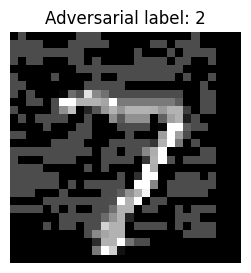

In [28]:
idx_adv3 = 0

plt.figure(figsize=(5, 3))
plt.imshow(x_test_adv3[idx_adv3].squeeze(), cmap='gray')
plt.title(f"Adversarial label: {np.argmax(adv_preds3[idx_adv3])}")
plt.axis('off')
plt.show()

## Train our model on these attacks

In [33]:
trainer = AdversarialTrainer(classifier, attacks=[attack, attack2, attack3], ratio=0.5)

In [34]:
trainer.fit(x_train, y_train, nb_epochs=5, batch_size=128)

Adversarial training epochs: 100%|██████████| 5/5 [24:46<00:00, 297.28s/it]


# Model Evaluation 

In [35]:
accuracy_res = {}

# Evaluate the ART classifier on adversarial test examples after adversarial training
for epsilon, attack in [(0.1, attack), (0.2, attack2), (0.3, attack3)]:
    adv_x_test = attack. generate(x=x_test)

    predictions = classifier.predict(adv_x_test)

    # Store accuracies of each epsilon value
    acc = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
    accuracy_res[epsilon] = acc

    print(f'Accuracy on adversarial test data with epsilon {epsilon}: {acc * 100:.2f}%')

Accuracy on adversarial test data with epsilon 0.1: 97.86%
Accuracy on adversarial test data with epsilon 0.2: 94.42%
Accuracy on adversarial test data with epsilon 0.3: 89.70%


In [99]:
# Evaluate the model on the original test data
predictions_original = classifier.predict(x_test)
accuracy_original = np.sum(np.argmax(predictions_original, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print(f"Accuracy on original test data: {accuracy_original * 100:.2f}%")

Accuracy on original test data: 99.37%


# Data Visualization

In [132]:
trained_epsilons = list(accuracy_res.keys())
trained_accuracies = list(accuracy_res.values())

# Convert accuracies to percentages for plotting
for i in range(len(trained_accuracies)):
    trained_accuracies[i] = trained_accuracies[i] * 100

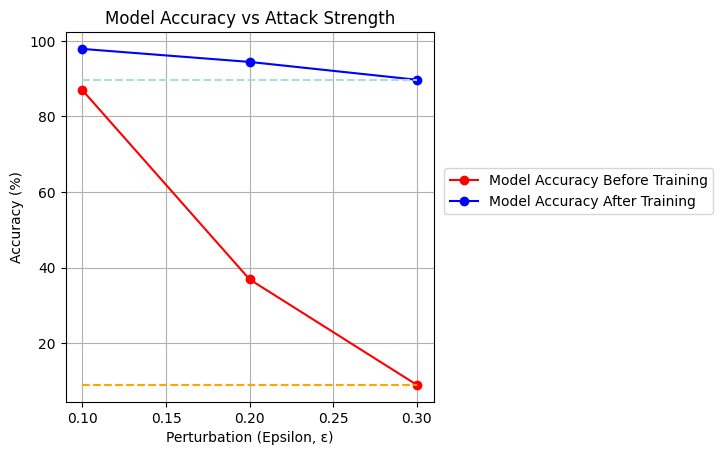

In [134]:
# Plot the attacks and their accuracies
# Plot the accuracies of the model after adversarial training
x = [0.1, 0.2, 0.3]
y = [accuracy*100, accuracy2*100, accuracy3*100]

plt.plot(x, y, marker='o', linestyle='-', color='r', label='Model Accuracy Before Training')
plt.plot(trained_epsilons, trained_accuracies, marker='o', linestyle='-', color='b', label='Model Accuracy After Training')

plt.hlines(y=trained_accuracies[2], xmin=0.1, xmax=0.3, colors='lightblue', linestyles='dashed')
plt.hlines(y=y[2], xmin=0.1, xmax=0.3, colors='orange', linestyles='dashed')

plt.xlabel('Perturbation (Epsilon, ε)')
plt.ylabel('Accuracy (%)')

plt.legend(bbox_to_anchor=(1.01, 0.65), loc='upper left')
plt.subplots_adjust(right=0.7)

plt.title('Model Accuracy vs Attack Strength')
plt.grid(True)
plt.show()